In [1]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imodelsx import KANClassifier
import shap
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import matplotlib.spines as spn
from sklearn import metrics
import seaborn as sns

C:\Users\HP\anaconda3\Lib\site-packages\shap\plots\colors\_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):
C:\Users\HP\anaconda3\Lib\site-packages\shap\plots\colors\_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):
C:\Users\HP\anaconda3\Lib\site-packages\shap\plots\colors\_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):
C:\Users\HP\anaconda3\Lib\site-packages\shap\plots\colors\_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated.

In [2]:
%%time
# Load data #
mergeddata=pd.read_csv("merged.csv")

CPU times: total: 0 ns
Wall time: 6.78 ms


In [3]:
# Separate features and target
features = mergeddata.iloc[:, :-1]  # All columns except the last one
target = mergeddata.iloc[:, -1]     # The last column
print(features.head(n=10))
print(target.head(n=10))
print(features.shape)
print(target.shape)

# Train test split and scale data #
X1,X2,y1,y2 =train_test_split(features, target, stratify=target, test_size= 0.30, random_state=42)
scaler = StandardScaler()
x1 = pd.DataFrame(scaler.fit_transform(X1))                
x2 = pd.DataFrame(scaler.transform(X2))
#print(x1.shape, x2.shape, y1.shape, y2.shape)
#print(x1.head(n=5),y1.head(n=5))
#print(x2.head(n=5),y2.head(n=5))

# To perform cross validation on train set #
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  

    83-148   83-149   83-150  123-299  161-176  168-297  172-174  256-291  \
0  6.98172  8.03743  8.49984  4.84695  4.78105  5.04026  4.63637  14.2376   
1  7.91593  8.46268  9.79619  5.72662  4.99733  5.13205  4.36940  15.1991   
2  3.19709  4.14582  5.59771  4.29520  4.94506  5.21529  5.01088  14.4558   
3  4.92428  2.19683  5.15414  5.15719  4.69634  5.01173  5.00048  14.3499   
4  3.36984  3.98278  5.10306  3.88632  5.00283  5.11213  4.98825  14.5466   
5  3.76155  4.44284  6.12459  4.90722  4.91182  5.37944  4.73117  13.8447   
6  5.76129  5.94946  7.25685  3.98009  4.72784  5.06096  5.00465  15.0830   
7  5.84664  5.19958  6.69821  3.70781  5.03388  5.10414  5.24649  15.4749   
8  2.59488  3.84461  5.27231  3.63808  4.57957  5.17273  5.16674  14.6314   
9  2.54641  4.31167  6.06185  5.17188  5.19962  4.58905  5.25533  15.7994   

   301-303    47-74  ...  215-259  232-238  259-283  297-299    32-55  \
0  5.40775  5.61842  ...  2.90620  5.11529  2.26574  2.96213  4.96796   
1  4.9

In [4]:
KAN = KANClassifier
base_model = KAN(hidden_layer_size=50, random_state=21)

# Model evaluation for cross validation on TRAIN DATASET #
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []

for train_index, test_index in cv.split(x1,y1):
    #print(len(train_index))
    #print(len(test_index))
    X_train, X_test = x1.iloc[train_index].to_numpy(), x1.iloc[test_index].to_numpy()
    y_train, y_test = y1.iloc[train_index].to_numpy(), y1.iloc[test_index].to_numpy()
    base_model.fit(X_train, y_train)
    y_pred = base_model.predict(X_test)

    cm_cv = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = cm_cv[0,0]/(cm_cv[0,0]+cm_cv[0,1])

    accuracy_scores.append(acc)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    specificity_scores.append(specificity)

avg_acc=np.mean(accuracy_scores)
avg_f1=np.mean(f1_scores)
avg_precision=np.mean(precision_scores)
avg_recall=np.mean(recall_scores)
avg_specificity=np.mean(specificity_scores)

scoredata = pd.DataFrame()
valscoredict = pd.DataFrame({'Data':'Validation','score_accuracy':avg_acc,'score_f1':avg_f1,'score_precision':avg_precision,'score_recall':avg_recall, 'score_specificity': avg_specificity}, index=["row"])
#scoredata=scoredata.append(valscoredict, ignore_index = True)
scoredata=pd.DataFrame(pd.concat([valscoredict, scoredata]))

# Model evaluation on TEST DATASET #

# Fit the base_model on whole train dataset to predict on test data
base_model.fit(x1.to_numpy(), y1.to_numpy())
y2_base_predict = pd.Series(base_model.predict(x2.to_numpy()))

cm_test = confusion_matrix(y2, y2_base_predict)
base_test_accuracy = accuracy_score(y2, y2_base_predict)
base_test_f1 = f1_score(y2, y2_base_predict)
base_test_precision = precision_score(y2, y2_base_predict)
base_test_recall = recall_score(y2, y2_base_predict)
base_test_specificity = cm_test[0,0]/(cm_test[0,0]+cm_test[0,1])

testscoredict = pd.DataFrame({'Data':'Test','score_accuracy':base_test_accuracy,'score_f1':base_test_f1,'score_precision':base_test_precision,'score_recall':base_test_recall, 'score_specificity': base_test_specificity}, index=["row"])
#scoredata=scoredata.append(testscoredict, ignore_index = True)
#scoredata=pd.DataFrame(pd.concat([testscoredict, scoredata], axis=1), index=None)
scoredata=pd.DataFrame(pd.concat([testscoredict, scoredata]))
print(scoredata)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.65it/s]

           Data  score_accuracy  score_f1  score_precision  score_recall  \
row        Test             1.0       1.0              1.0           1.0   
row  Validation             1.0       1.0              1.0           1.0   

     score_specificity  
row                1.0  
row                1.0  


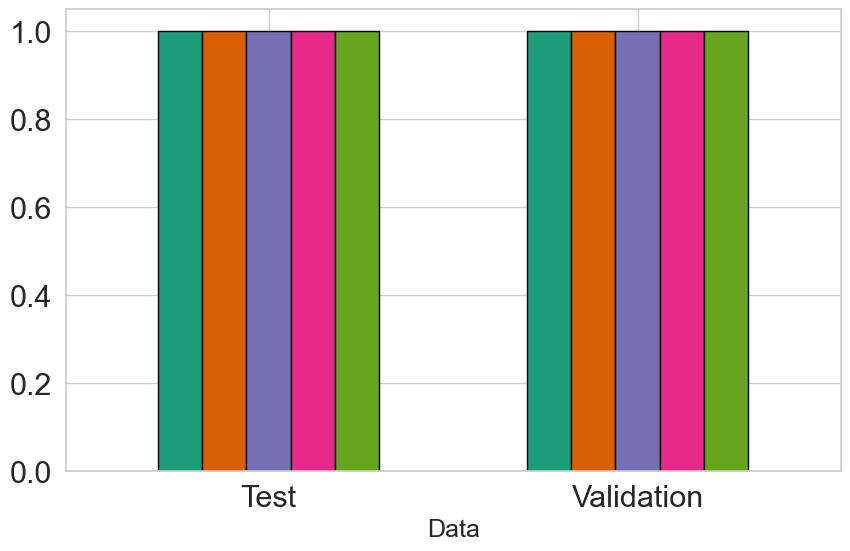

In [5]:
## PLOTS for BASE MODEL ##
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")

# Plot classification scores #
c = plt.get_cmap('Dark2')
scoredata.plot.bar(x="Data", rot=0, width=0.6, figsize=(10,6), fontsize=22, legend=False, edgecolor="black", linewidth=1, color = c.colors)
plt.savefig("KANshapoutputs/KAN-barplot.png", dpi=300)
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

CPU times: total: 15.4 s
Wall time: 4.55 s


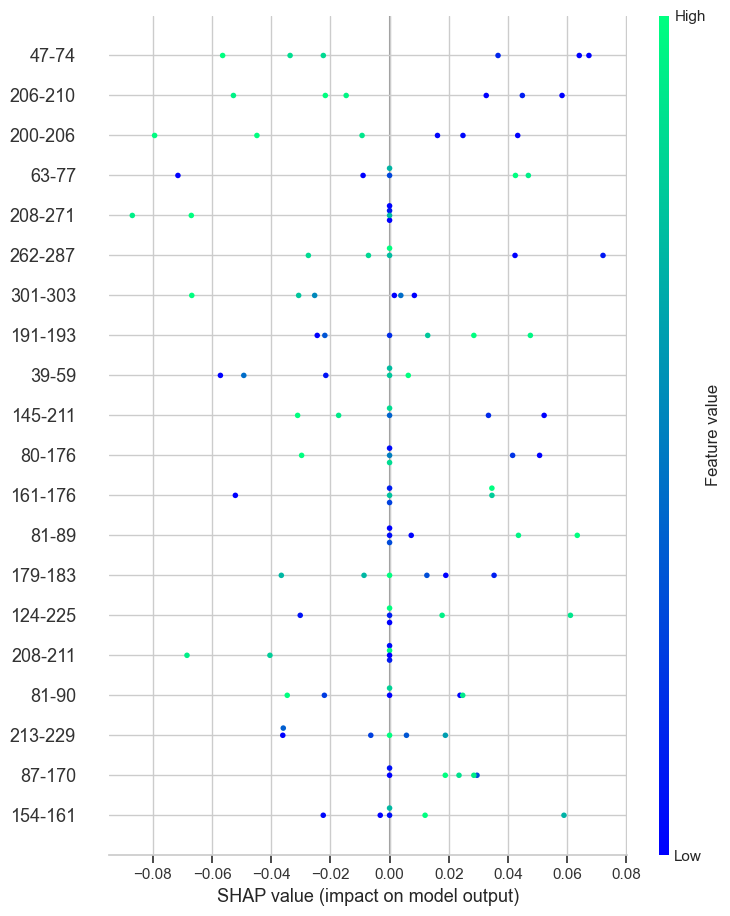

In [6]:
%%time 
# Do a SHAP feature ranking #
explainer = shap.KernelExplainer(base_model.predict, x1.to_numpy())
shap_values = explainer.shap_values(x2.to_numpy(), l1_reg='num_features(30)', nsamples=250)
plt.figure()
shap.summary_plot(shap_values, x2, feature_names=features.columns, show=False, cmap=plt.get_cmap("winter"))
plt.savefig("KANshapoutputs/KAN-topshapfeatures-swarmplot.png", dpi=300)

       Pair  Importance
9     47-74    0.046736
25  206-210    0.037477
24  200-206    0.036288
35    63-77    0.028305
54  208-271    0.025645
..      ...         ...
42   89-141    0.000121
12  121-303    0.000000
10    58-93    0.000000
31  288-294    0.000000
52  199-207    0.000000

[66 rows x 2 columns]


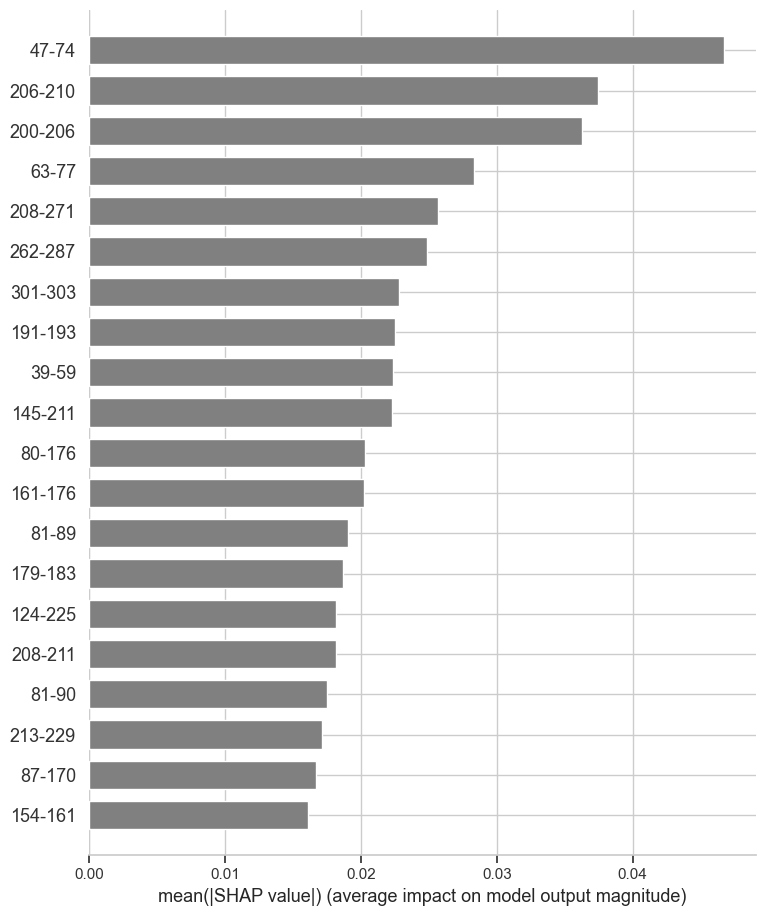

In [7]:
# Do a feature rank plot #
feature_names = features.columns
plt.figure()
shap.summary_plot(shap_values, x2, plot_type="bar", show=False, color="grey", feature_names=feature_names)
plt.savefig("KANshapoutputs/KAN-topshapfeatures-rankplot.png", dpi=300)

# Save Data #
shap_df = pd.DataFrame(shap_values, columns=features.columns)
vals = np.abs(shap_df.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['Pair', 'Importance'])
shap_importance.sort_values(by=['Importance'], ascending=False, inplace=True)
shap_importance.to_csv("KANshapoutputs/KANshapscore.csv", sep=",", index=False)
print(shap_importance)

In [8]:
import pickle
# Save the shap explainer object and values for quick load and ready reference #
filename_expl = 'KANshapoutputs/KANexplainer.sav'
filename = 'KANshapoutputs/KANshapvalues.sav'
pickle.dump(explainer, open(filename_expl, 'wb'))
pickle.dump(shap_values, open(filename, 'wb'))